Script for solving the one dimensional Schroedinger equation numerically.

Numerical integration method used is the fourth order Runge Kutta.
Counts the nodes of the wave function and determins the harmonic.
Then refines the solution until proper energy is found.

Potentials:
Infinite Potential Well
$$
    V(x \leq 0) = \inf, ~~ V(x = 0, 1) = 0, ~~ V(x \geq 1) = \inf
$$
Analitic solution:
$$ 
    sin(k  \pi  x)
$$

Harmonic Oscillator:
$$ 
    V(x) = x ^ 2
$$
Analitic solution:
$$
    \frac{1}{\sqrt{2 ^ n  n!}} H(x) * \exp(- \frac{x ^ 2}{2})
$$

Radial Hydrogen Atom Coulomb attraction:
$$
    V(r) = \frac{2}{r} - \frac{L (L + 1)} {r ^ 2}
$$

In [2]:
import pandas as pd
import sympy as smp
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation

import math

import scipy
from scipy import integrate
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy.optimize import newton

In [3]:
def RungeKutta4(f, x, y_0, params : list):
    """ Fourth-order Runge-Kutta method to solve psi' = f(psi, x) with psi(x[0]) = psi0.

        Integrates function f with inital values psi0 numerically.
        Output is possible multidimensional (in psi) array with len(x).
    """

    n = len(x)
    res = np.zeros(shape = (n, len(y_0)))
    res[0] = y_0

    for i in range(n - 1):
        h = x[i + 1] - x[i]
        
        f_1 = f(res[i]                  , x[i],             params)
        f_2 = f(res[i] + 1 / 2 * h * f_1, x[i] + 1 / 2 * h, params)
        f_3 = f(res[i] + 1 / 2 * h * f_2, x[i] + 1 / 2 * h, params)
        f_4 = f(res[i] +         h * f_3, x[i] +         h, params)

        res[i + 1] = res[i] + h * (1 / 6 * f_1 + 
                                   2 / 6 * f_2 + 
                                   2 / 6 * f_3 + 
                                   1 / 6 * f_4)
        
    return res

def findZeros(rightbound_vals):
    """ Find zero crossing due to sign change in rightbound_vals array.
        Return array with array indices before sign change occurs. 
    """
    return np.where(np.diff(np.signbit(rightbound_vals)))[0]

def normalize(output_wavefunc):
    """ A function to roughly normalize the wave function to 1. """
    # res = 0

    # for i in output_wavefunc:
    #     res += i ** 2
    
    # return output_wavefunc / np.sqrt(res)
    # return output_wavefunc / max(np.abs(output_wavefunc))

    return output_wavefunc / max(output_wavefunc)

def shoot(func, x, psi0, params : list, alpha_arr):
    """ Shooting method: find zeroes of function func for energies in alpha_arr. 
   
        func      : Schroedinger equation to solve.
        psi0      : initial conditions on left side, can be array.
        alpha_arr : array of parameter values : find possible zeroes.
    """

    psi_rightb = []

    for i in alpha_arr:
        params.insert(1, i)
        psi = RungeKutta4(func, x, psi0, params)
        params.pop(1)
        psi_rightb.append(psi[-1][0])

    return np.asarray(psi_rightb)

def shootRK4(alpha, func, x, psi0, params : list):
    """ Helper function for optimizing results. """

    params.insert(1, alpha)
    psi = RungeKutta4(func, x, psi0, params)
    params.pop(1)

    return psi[-1][0]

def shoot_ode(alpha, func, x, psi0, params : list):
    """ Helper function for optimizing resuts. """

    params.insert(1, alpha)
    psi = integrate.odeint(func, psi0, x, args = (params,))
    params.pop(1)
    
    return psi[-1][0]

def optimizeAlphaNewton(func, x, psi0, params : list, alpha_arr):
    """ Optimize alpha value for function using brentq. """
    
    shoot_try = shoot(func, x, psi0, params, alpha_arr)
    crossings = findZeros(shoot_try)
    alpha_list = []

    for cross in crossings :
        alpha_list.append(newton(shootRK4, alpha_arr[cross], args = (func, x, psi0, params)))
                                                                          
    return np.asarray(alpha_list)


In [4]:
def V_fpw_(x, params):
    a   = params[0]
    V_0 = params[1]

    if (np.abs(x - 0.5) <= a):
        return 0
    else:
        return V_0
    
def V_ipw_(x, params):
    return 0

def V_qho_(x, params):
    return x ** 2

def V_hydrogen_(x, params):
    L = params[0]

    return (L * (L + 1)) / (x ** 2) - 2.0 / x


In [5]:
def IPW_ana(x, k):
    """ Return analitical wavefunc of respective state (k) of IPW. """
    return np.asarray(np.sin(k * np.pi * x))

def QHO_ana(x, nodes):
    """ Return analitic solution for QHO for up to5 nodes. """
    if (nodes == 1):
        return np.exp(-(x) ** 2 / 2)
    elif (nodes == 2):
        return np.sqrt(2.0) * (x) * np.exp(-(x) ** 2 / 2) * (-1)
    elif (nodes == 3):
        return (1.0 / np.sqrt(2.0)) * (2.0 * (x) ** 2 - 1.0) * np.exp(- (x) ** 2 / 2)
    elif (nodes == 4):
        return (1.0 / np.sqrt(3.0)) * (2.0 * (x) ** 3 - 3.0 * x) * np.exp(-(x) ** 2 / 2)*( -1)
    elif (nodes == 5):
        return (1.0 / np.sqrt(24.0)) * (4.0 * (x) ** 4 - 12.0 * x ** 2 + 3.0) * np.exp(-(x)**2/2)
    else:
        print("No analytic wave function found. Please try again.")
        print("Output will be zero array.")
        return np.zeros(len(x))

def HYDRO_ana(x, N, L):
    """ Return analytical solution for Hydrogen SE. """
    
    # analytical solution hydrogen for N =1
    if (((N - L - 1) == 0) and (L == 0)):
        # return 2.0* np . exp ( - x /2)* x
        return x * np.exp(-x)
    
    elif (((N - L - 1) == 1) and (L == 0)):
        return (np.sqrt(2.0) * (- x + 2.0) * np.exp(-x / 2.0) / 4.0) * x
    
    elif (((N - L - 1) == 2)):
        return (2.0 * np.sqrt(3.0) * (2.0 * x ** 2 / 9.0 - 2.0 * x + 3.0) * np.exp(-x / 3.0) / 27.0) * x
    
    elif (((N - L - 1) == 0) and (L == 1)):
        return (np.sqrt(6.0) * x * np.exp(-x / 2.0) / 12.0) * x
    
    else:
        print("No analytic wave function found. Please try again.")
        print("Output will be zero array.")
        return np.zeros(len(x))


In [6]:
def Schroed(y, x, params : list):
    """ Return one dim Schroedinger equation with Potential V. 

        psi' = phi
        phi' = (V - E) * psi
    """

    psi, phi = y

    V = 0

    if (len(params) > 2):
        V = params[0](x, params[2:])
    else:
        V = params[0](x, [])
    E = params[1]
    
    dphidx = [phi, (V - E) * psi]

    return np.asarray(dphidx)

def countNodes(wavefunc):
    """ Count nodes of wavefunc by finding Minima and Maxima in wavefunc. """
    maxarray = argrelextrema(wavefunc, np.greater)[0]
    minarray = argrelextrema(wavefunc, np.less)[0]
    
    nodecounter = len(maxarray) + len(minarray)

    return nodecounter

def RefineEnergy(Ebot, Etop, nodes, x, psi0, params):
    tolerance = 1e-12

    ET = Etop
    EB = Ebot

    psi = [1]

    while (abs(EB - ET) > tolerance or abs(psi[-1]) > 1e-3):
        print(EB, ET)
        initE = (ET + EB) / 2.0

        params.insert(1, initE)
        psi = RungeKutta4(Schroed, x, psi0, params)[:, 0]
        # psi = integrate.odeint(Schroed, psi0, x, args = (params,))[: , 0]
        params.pop(1)

        nodes_ist = len(findZeros(psi)) - 1
        if nodes_ist > nodes + 1:
            ET = initE
            continue
        if nodes_ist < nodes - 1:
            EB = initE
            continue

        if (nodes_ist % 2 == 0):
            if ((psi[-1] <= 0.0)):
                ET = initE
            else:
                EB = initE
        elif nodes_ist > 0:
            if ((psi[-1] <= 0.0)):
                EB = initE
            else :
                ET = initE
        elif nodes_ist < 0:
            EB = initE

        if (EB + tolerance >= Etop):
            print("Increase Etop")
            break
        if (ET - tolerance <= Ebot):
            print("Decrease Ebot")
            break

    return EB, ET


In [7]:
def plot_wavefunction(fig, title_string, x_arr, num_arr, ana_arr, axis_list):
    """ Output plots for wavefunctions. """
    # clear plot
    plt.cla() # clear axis
    plt.clf() # clear figure

    plt.plot(x_arr, num_arr, 'b:', linewidth = 4, label = r"$\Psi(\hat{x})_{num}$")
    plt.plot(x_arr, normalize(ana_arr), 'r-', label = r"$\Psi(\hat{x})_{ana}$")

    plt.ylabel(r"$\Psi(\hat{x})$", fontsize = 16)
    plt.xlabel(r'$\hat{x}$', fontsize = 16)
    plt.legend(loc = 'best', fontsize = 'small')

    plt.axis(axis_list)
    plt.title(title_string)
    plt.grid()

    fig.savefig("plots/wavefunc_" + title_string + ".png")

/tmp/ipykernel_2193/322691054.py:43: RuntimeWarning: invalid value encountered in divide
  return output_wavefunc / max(output_wavefunc)


3


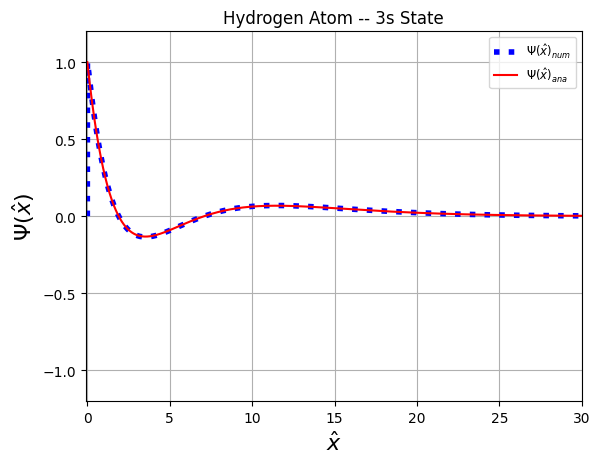

In [8]:
def shoot_potwell(psi_init, h_):
    """ Shooting method for infinte potential well.

        500 mesh points.

        Returns the numerical and analitical solution as arrays.
    """

    x_arr_ipw = np.arange(0.0, 1.0 + h_, h_)
    E_arr = np.arange(1.0, 100.0, 5.0)

    eigE = optimizeAlphaNewton(Schroed, x_arr_ipw, psi_init, [V_ipw_], E_arr)
                          
    ipw_out_list = []

    for EI in eigE:
        out = RungeKutta4(Schroed, x_arr_ipw, psi_init, [V_ipw_, EI])
        ipw_out_list.append(normalize(out[:, 0]))
    
    out_arr = np.asarray(ipw_out_list)

    # analitical solution for IPW
    k = np.arange(1.0, 4.0, 1.0)
    ipw_sol_ana = []

    for i in k :
        ipw_sol_ana.append(np.sin(i * np.pi * x_arr_ipw))
    
    ipw_sol_ana_arr = np.asarray(ipw_sol_ana)

    return x_arr_ipw, out_arr, ipw_sol_ana_arr

def shoot_finite_potwell(psi_init, h_, a, V0):
    """ Shooting method for finite potential well.

        500 mesh points.

        Returns the numerical solution as arrays.
    """

    x_arr_ipw = np.arange(0.0, 1.0 + h_, h_)
    E_arr = np.arange(1.0, 8000.0, 1.0)

    eigE = optimizeAlphaNewton(Schroed, x_arr_ipw, psi_init, [V_fpw_, a, V0], E_arr)
                          
    ipw_out_list = []

    for EI in eigE:
        out = RungeKutta4(Schroed, x_arr_ipw, psi_init, [V_fpw_, EI, a, V0])
        ipw_out_list.append(normalize(out[:, 0]))
    
    out_arr = np.asarray(ipw_out_list)

    return x_arr_ipw, out_arr, np.zeros(len(x_arr_ipw))

def shoot_QuantumHarmonicOscllator(psi_init, h_):   
    """ Shooting method for quantum harmonic oscllator.

        500 mesh points.

        Returns the numerical and analitycal solution as arrays.
    """

    x_arr_qho = np.arange(-5.0, 5.0 + h_, h_)
    E_arr = np.arange(1.0, 15.0, 1.0)
    eigEn = optimizeAlphaNewton(Schroed, x_arr_qho, psi_init, [V_qho_], E_arr)
    
    qho_out_list = []
    
    for EN in eigEn:
        out = RungeKutta4(Schroed, x_arr_qho, psi_init, [V_qho_, EN])
        qho_out_list.append(normalize(out[:, 0]))
    
    qho_out_arr = np.asarray(qho_out_list)
    
    # analitical solution for QHO
    qho_sol_ana_0 = np.exp(-(x_arr_qho) ** 2 / 2)
    qho_sol_ana_1 = np.sqrt(2.0) * (x_arr_qho) * np.exp(-(x_arr_qho) ** 2 / 2) * ( - 1)
    qho_sol_ana_2 = (1.0 / np.sqrt(2.0)) * (2.0 * (x_arr_qho) ** 2 - 1.0) * np.exp(-(x_arr_qho) ** 2 / 2)

    qho_sol_list = []
    qho_sol_list.append(qho_sol_ana_0)
    qho_sol_list.append(qho_sol_ana_1)
    qho_sol_list.append(qho_sol_ana_2)

    return x_arr_qho, qho_out_arr, np.asarray(qho_sol_list)

def shoot_hydrogen(psi_init, h_, L):
    """ Shooting method for Schrodinger equation of the Hydrogen atom.

        Returns the numerical solution as array.
    """

    x_arr_hydro = np.arange(0.0001, 35.0 + h_, h_)
    E_arr = np.arange(-1.0, 0.0, 0.001)
    rightb = []
    
    for EE in E_arr:
        psi = integrate.odeint(Schroed, psi_init, x_arr_hydro, args = ([V_hydrogen_, EE, L],))[: , 0]
        rightb.append(psi[-1])

    rightb_arr = np.asarray(rightb)
    crossings = findZeros(rightb_arr)
    
    energy_l = []
    for cross in crossings:
        energy_l.append(newton(shoot_ode, E_arr[cross], args = (Schroed, x_arr_hydro, psi_init, [V_hydrogen_, L])))
    
    psi_out = []
    for En in energy_l:
        psi_out.append(integrate.odeint(Schroed, psi_init, x_arr_hydro, args = ([V_hydrogen_, En, L],))[: , 0])
    
    return x_arr_hydro, np.asarray(psi_out)
    
# Initial conditions for pot.well and harmonic ocs
psi_init = np.asarray([0.0, 1.0])

a = 0.05
V0 = 8000

h_ = 1.0 / 1000.0 # step size for range arrays

fig = plt.figure()

ipw_x, ipw_num, ipw_ana = shoot_potwell(psi_init, h_)
fpw_x, fpw_num, zero = shoot_finite_potwell(psi_init, h_, a, V0)
qho_x, qho_num, qho_ana = shoot_QuantumHarmonicOscllator(psi_init, h_)
hydro_x, hydro_num = shoot_hydrogen(psi_init, h_, 0)
hydro_x2p , hydro_num2p = shoot_hydrogen (psi_init, h_, 1)
hydro_ana1s = HYDRO_ana(hydro_x, 1 , 0)
hydro_ana2s = HYDRO_ana(hydro_x, 2 , 0)
hydro_ana3s = HYDRO_ana(hydro_x, 3 , 0)
hydro_ana2p = HYDRO_ana(hydro_x, 2 , 1)

# IPW shooting
plot_wavefunction(fig, "Infinite Potential Well -- Ground State",         ipw_x, ipw_num[0, :], ipw_ana[0, :], [-0.1, 1.1, -0.2, 1.2])
plot_wavefunction(fig, "Infinite Potential Well -- First Excited State",  ipw_x, ipw_num[1, :], ipw_ana[1, :], [-0.1, 1.1, -1.2, 1.2])
plot_wavefunction(fig, "Infinite Potential Well -- Second Excited State", ipw_x, ipw_num[2, :], ipw_ana[2, :], [-0.1, 1.1, -1.2, 1.2])

# FPW shooting
plot_wavefunction(fig, "Finite Potential Well -- Ground State",         fpw_x, fpw_num[0, :], zero, [-0.1, 1.1, -1.2, 1.2])
plot_wavefunction(fig, "Finite Potential Well -- First Excited State",  fpw_x, fpw_num[1, :], zero, [-0.1, 1.1, -1.2, 1.2])
plot_wavefunction(fig, "Finite Potential Well -- Second Excited State", fpw_x, fpw_num[2, :], zero, [-0.1, 1.1, -1.2, 1.2])
print(len(fpw_num))

# QHO shooting
plot_wavefunction(fig, "Quantum Harmonic Oscillator -- Ground State",         qho_x, qho_num[0, :], qho_ana[0, :], [-5.2, 5.2, -1.2, 1.2])
plot_wavefunction(fig, "Quantum Harmonic Oscillator -- First Excited State",  qho_x, qho_num[1, :], qho_ana[1, :], [-5.2, 5.2, -1.2, 1.2])
plot_wavefunction(fig, "Quantum Harmonic Oscillator -- Second Excited State", qho_x, qho_num[2, :], qho_ana[2, :], [-5.2, 5.2, -1.2, 1.2])

# Hydrogen Atom shooting
plot_wavefunction(fig, "Hydrogen Atom -- 1s State", hydro_x,   normalize(hydro_num[0, :] / hydro_x),   hydro_ana1s / hydro_x, [-0.1, 30.0, -0.1, 1.2])
plot_wavefunction(fig, "Hydrogen Atom -- 2s State", hydro_x,   normalize(hydro_num[1, :] / hydro_x),   hydro_ana2s / hydro_x, [-0.1, 30.0, -2.2, 1.2])
plot_wavefunction(fig, "Hydrogen Atom -- 2p State", hydro_x2p, normalize(hydro_num2p[0, :] / hydro_x), hydro_ana2p / hydro_x, [-0.1, 30.0, -0.1, 1.2])
plot_wavefunction(fig, "Hydrogen Atom -- 3s State", hydro_x,   normalize(hydro_num[2, :] / hydro_x),   hydro_ana3s / hydro_x, [-0.1, 30.0, -1.2, 1.2])

1.0 900.0
1.0 450.5
1.0 225.75
1.0 113.375
1.0 57.1875
1.0 29.09375
1.0 15.046875
8.0234375 15.046875
8.0234375 11.53515625
9.779296875 11.53515625
9.779296875 10.6572265625
9.779296875 10.21826171875
9.779296875 9.998779296875
9.779296875 9.8890380859375
9.83416748046875 9.8890380859375
9.861602783203125 9.8890380859375
9.861602783203125 9.875320434570312
9.868461608886719 9.875320434570312
9.868461608886719 9.871891021728516
9.868461608886719 9.870176315307617
9.869318962097168 9.870176315307617
9.869318962097168 9.869747638702393
9.86953330039978 9.869747638702393
9.86953330039978 9.869640469551086
9.869586884975433 9.869640469551086
9.869586884975433 9.86961367726326
9.869600281119347 9.86961367726326
9.869600281119347 9.869606979191303
9.869603630155325 9.869606979191303
9.869603630155325 9.869605304673314
9.86960446741432 9.869605304673314
9.86960446741432 9.869604886043817
9.86960446741432 9.869604676729068
9.86960446741432 9.869604572071694
9.869604519743007 9.869604572071694
9

/tmp/ipykernel_2193/322691054.py:43: RuntimeWarning: invalid value encountered in divide
  return output_wavefunc / max(output_wavefunc)


12.5875 25.075
12.5875 18.83125
12.5875 15.709375000000001
12.5875 14.1484375
12.5875 13.36796875
12.977734375 13.36796875
12.977734375 13.1728515625
12.977734375 13.07529296875
12.977734375 13.026513671875001
12.977734375 13.002124023437501
12.98992919921875 13.002124023437501
12.996026611328126 13.002124023437501
12.999075317382815 13.002124023437501
13.000599670410157 13.002124023437501
13.000599670410157 13.001361846923828
13.000980758666993 13.001361846923828
13.00117130279541 13.001361846923828
13.00117130279541 13.001266574859619
13.00117130279541 13.001218938827513
13.001195120811461 13.001218938827513
13.001195120811461 13.001207029819486
13.001201075315475 13.001207029819486
13.00120405256748 13.001207029819486
13.00120405256748 13.001205541193483
13.001204796880483 13.001205541193483
13.001204796880483 13.001205169036982
13.001204796880483 13.001204982958733
13.001204796880483 13.001204889919608
13.001204796880483 13.001204843400046
13.001204820140265 13.001204843400046
13.0

KeyboardInterrupt: 

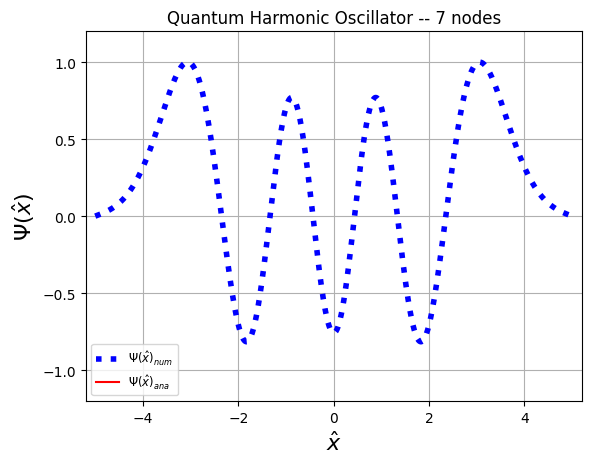

In [9]:
def ShootingInfinitePotentialWell(E_interval, nodes):
    """ Implimentation of Shooting method for Infinite Potential Well
        
        INPUT : E_interval : array with top and bottom value, len(E_inteval) = 2
                nodes : Number wavefunction nodes => determins quantum state.
        OUTPUT : refined energy value numeracal wavefunction as array.
    """

    psi_init = np.asarray([0.0, 1.0])
    
    h_mesh = 1.0 / 100.0 # step size for range arrays
    x_arr_ipw = np.arange(0.0, 1.0 + h_mesh, h_mesh) # set up mesh
    
    EBref, ETref = RefineEnergy(E_interval[0], E_interval[1], nodes, x_arr_ipw, psi_init, [V_ipw_])

    psi = RungeKutta4(Schroed, x_arr_ipw, psi_init, [V_ipw_, EBref])[:, 0]

    return EBref, normalize(psi), x_arr_ipw

def ShootingFinitePotentialWell(E_interval, nodes, a, V0):
    """ Shooting FPW. """

    psi_init = np.asarray([0.0, 1.0])
    
    h_mesh = 1.0 / 1000.0 # step size for range arrays
    x_arr_ipw = np.arange(0.0, 1.0 + h_mesh, h_mesh) # set up mesh
    
    EBref, ETref = RefineEnergy(E_interval[0], E_interval[1], nodes, x_arr_ipw, psi_init, [V_fpw_, a, V0])

    psi = RungeKutta4(Schroed, x_arr_ipw, psi_init, [V_fpw_, EBref, a, V0])[:, 0]

    return EBref, normalize(psi), x_arr_ipw


def ShootingQuantumHarmonicOscillator(E_interval, nodes):
    """ Shooting QHO. """

    psi_init = np.asarray([0.0, 1.0])

    h_mesh = 1.0 / 100.0 # step size for range arrays

    x_arr_qho = np.arange(-5.0, 5.0 + h_mesh, h_mesh) # set up mesh
    
    EBref, ETref = RefineEnergy(E_interval[0], E_interval[1], nodes, x_arr_qho, psi_init, [V_qho_])
    
    psiB = RungeKutta4(Schroed, x_arr_qho, psi_init, [V_qho_, EBref])[:, 0]
    psiT = RungeKutta4(Schroed, x_arr_qho, psi_init, [V_qho_, ETref])[:, 0]
    
    return EBref, ETref, normalize(psiB), normalize(psiT), x_arr_qho

def ShootingHydrogenAtom(E_interval, N, L):
    """ Shooting method for quantum harmonic oscillator .
        Returns the numerical wave function as array .
    """

    psi_init = np.asarray([0.0, 1.0]) # Init cond for hydrogen

    h_ = 1.0 / 200.0
    x_arr_hydro = np.arange(1e-7, 35.0 + h_, h_)

    nodes = N - L  # Number of should be nodes
   
    EBref, ETref = RefineEnergy(E_interval[0], E_interval[1], nodes, x_arr_hydro, psi_init, [V_hydrogen_, L])
    Enewton = newton(shoot_ode, EBref, args = (Schroed, x_arr_hydro, psi_init, [V_hydrogen_, L]),) 
    
    psi = integrate.odeint(Schroed, psi_init, x_arr_hydro, args = ([V_hydrogen_, Enewton, L],))[: , 0]

    return Enewton, normalize(psi), x_arr_hydro


a = 0.01
V0 = 4000

# Start
E_qho = [0.1 , 100.0]
E_ipw = [1.0 , 900.0]
E_fpw = [0.1, V0 - 1e-11]
E_hydro = [-9.0, 30]

nodes_arr = np.arange(1, 10, 1)

fig = plt.figure()

for i in nodes_arr:
    Energy, psi_ipw , x_ipw = ShootingInfinitePotentialWell(E_ipw, i)
    psi_ana = normalize(IPW_ana(i, x_ipw))

    plot_wavefunction(fig, "Infinite Potential Well -- %s nodes" % (i), x_ipw, psi_ipw, psi_ana, [-0.1, 1.1, -1.2, 1.2])

for i in nodes_arr:
    EB, ET, psibot, psitop, x_qho = ShootingQuantumHarmonicOscillator(E_qho, i)
    psi_ana = QHO_ana(x_qho, i)

    plot_wavefunction(fig, "Quantum Harmonic Oscillator -- %s nodes" % (i), x_qho, psibot, psi_ana, [-5.2, 5.2, -1.2, 1.2])

for i in nodes_arr:
    Energy, psi_fpw, x_fpw = ShootingFinitePotentialWell(E_fpw, i, a, V0)
    psi_ana = np.zeros(len(psi_fpw))

    plot_wavefunction(fig, "Finite Potential Well -- %s nodes" % (i), x_fpw, psi_fpw, psi_ana, [-0.1, 1.1, -1.2, 1.2])

fig = plt.figure()

nodes = np.arange(1, 4, 1)
for i in nodes:
    E, psi_hydro, x_arr_hydro, = ShootingHydrogenAtom(E_hydro, i, 0)
    hydro_ana = HYDRO_ana(x_arr_hydro, i, 0)
    
    plot_wavefunction(fig, "Hydrogen Atom -- %ss State (2)" % (i), x_arr_hydro, psi_hydro, hydro_ana, [-0.1, 30.0, -2.2, 1.2])

E, psi_hydro, x_arr_hydro, = ShootingHydrogenAtom(E_hydro, 2, 1)
hydro_ana = HYDRO_ana(x_arr_hydro, 2, 1)

plot_wavefunction(fig, "Hydrogen Atom -- 2p State (2)" % (i), x_arr_hydro, psi_hydro, hydro_ana, [-0.1, 30.0, -2.2, 1.2])